In [6]:
!pip install datasets
!pip install langchain
!pip install ctransformers
!pip install nltk
!pip install faiss-cpu
!pip install faiss-gpu

In [7]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [9]:
from datasets import load_dataset


dataset = load_dataset("hugginglearners/netflix-shows", split="train")
df = pd.DataFrame(dataset)

In [6]:
df = pd.DataFrame(dataset)
df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,None,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,None,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",None,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,None,None,None,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,None,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
8803,s8804,TV Show,Zombie Dumb,None,None,None,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [11]:
print(df.columns)



Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')


In [12]:
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(df['description'])


In [13]:
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_tfidf)
df['cluster_label'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


                                                                                 precision    recall  f1-score   support

                                                             Action & Adventure       0.26      0.41      0.32        27
                   Action & Adventure, Anime Features, Children & Family Movies       1.00      0.00      0.00         1
                             Action & Adventure, Anime Features, Classic Movies       1.00      0.00      0.00         1
                       Action & Adventure, Anime Features, International Movies       1.00      0.00      0.00         8
                           Action & Adventure, Anime Features, Sci-Fi & Fantasy       1.00      0.00      0.00         1
                   Action & Adventure, Children & Family Movies, Classic Movies       1.00      0.00      0.00         1
                         Action & Adventure, Children & Family Movies, Comedies       1.00      0.00      0.00         1
                 Action & Adven

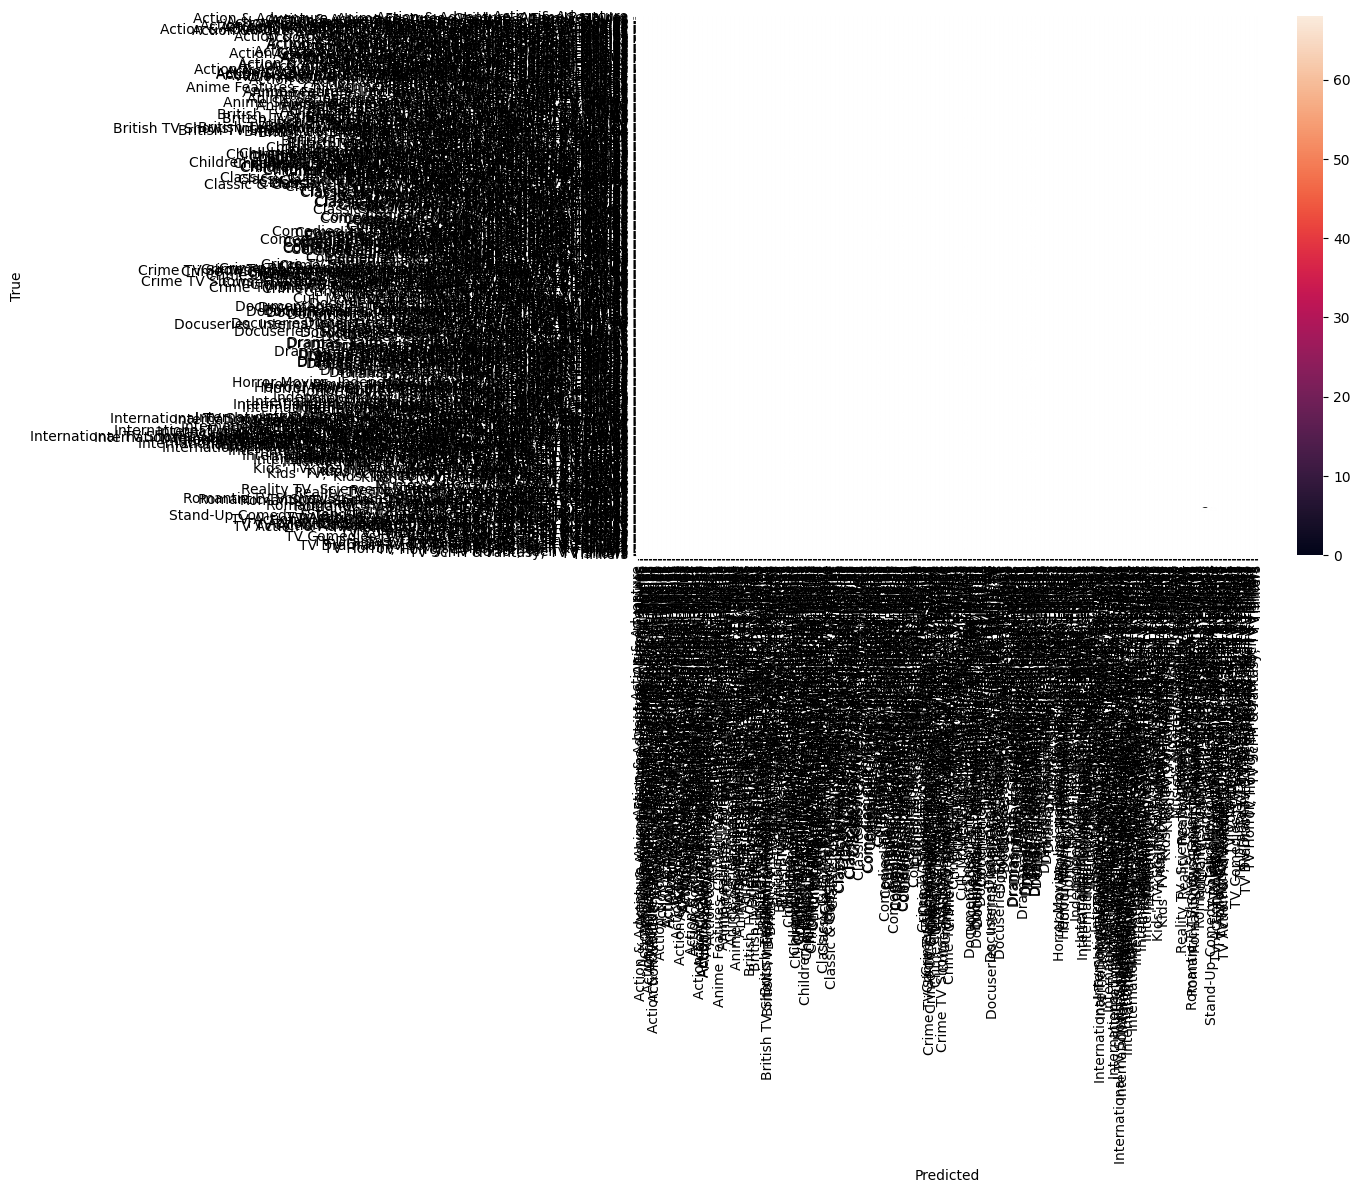

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df[['description', 'cluster_label']], df['listed_in'], test_size=0.2, random_state=42)
X_train_tfidf = vectorizer.transform(X_train['description'])
X_test_tfidf = vectorizer.transform(X_test['description'])

import scipy
X_train_tfidf = scipy.sparse.hstack((X_train_tfidf, np.array(X_train['cluster_label'])[:,None]))
X_test_tfidf = scipy.sparse.hstack((X_test_tfidf, np.array(X_test['cluster_label'])[:,None]))

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred, zero_division=1))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from collections import defaultdict

X = df['description']
y = df['listed_in']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
# Define and train the logistic regression model
model = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=1000)),
    ("clf", LogisticRegression(max_iter=1000))
])

# Train the model with the training data
model.fit(X_train, y_train)

# Predict genres for the descriptions in the entire dataset
predicted_genres = model.predict(df['description'])


In [22]:
genre_buckets = defaultdict(list)

# populate buckets w/ initial predictions
for i, (description, predicted_genre) in enumerate(zip(df['description'], predicted_genres)):
    genre_buckets[predicted_genre].append({
        'id': df['show_id'][i],
        'description': description,
        'metadata': {
            'actual_genre': df['listed_in'][i],
            'predicted_genre': predicted_genre,
        }
    })

In [27]:
temp_genre_buckets = defaultdict(list)
# Determine incorrect items that do not fit each category
for genre, items in genre_buckets.items():
    for item in items:
        actual_genre = item['metadata']['actual_genre'].split(', ')[0]  # Simplifying to primary genre
        if actual_genre != genre:
            temp_genre_buckets[actual_genre].append(item)

In [28]:
# move the items to the correct buckets and remove them from the old buckets
for genre, items in temp_genre_buckets.items():
    for item in items:
        genre_buckets[genre].append(item)  # add to the correct bucket
        genre_buckets[item['metadata']['predicted_genre']].remove(item) #remove old bucket

In [29]:
# calculating the correct accuracy
accuracies = {}
for genre, items in genre_buckets.items():
    correct_predictions = sum(1 for item in items if genre in item['metadata']['actual_genre'])
    total_predictions = len(items)
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    accuracies[genre] = accuracy

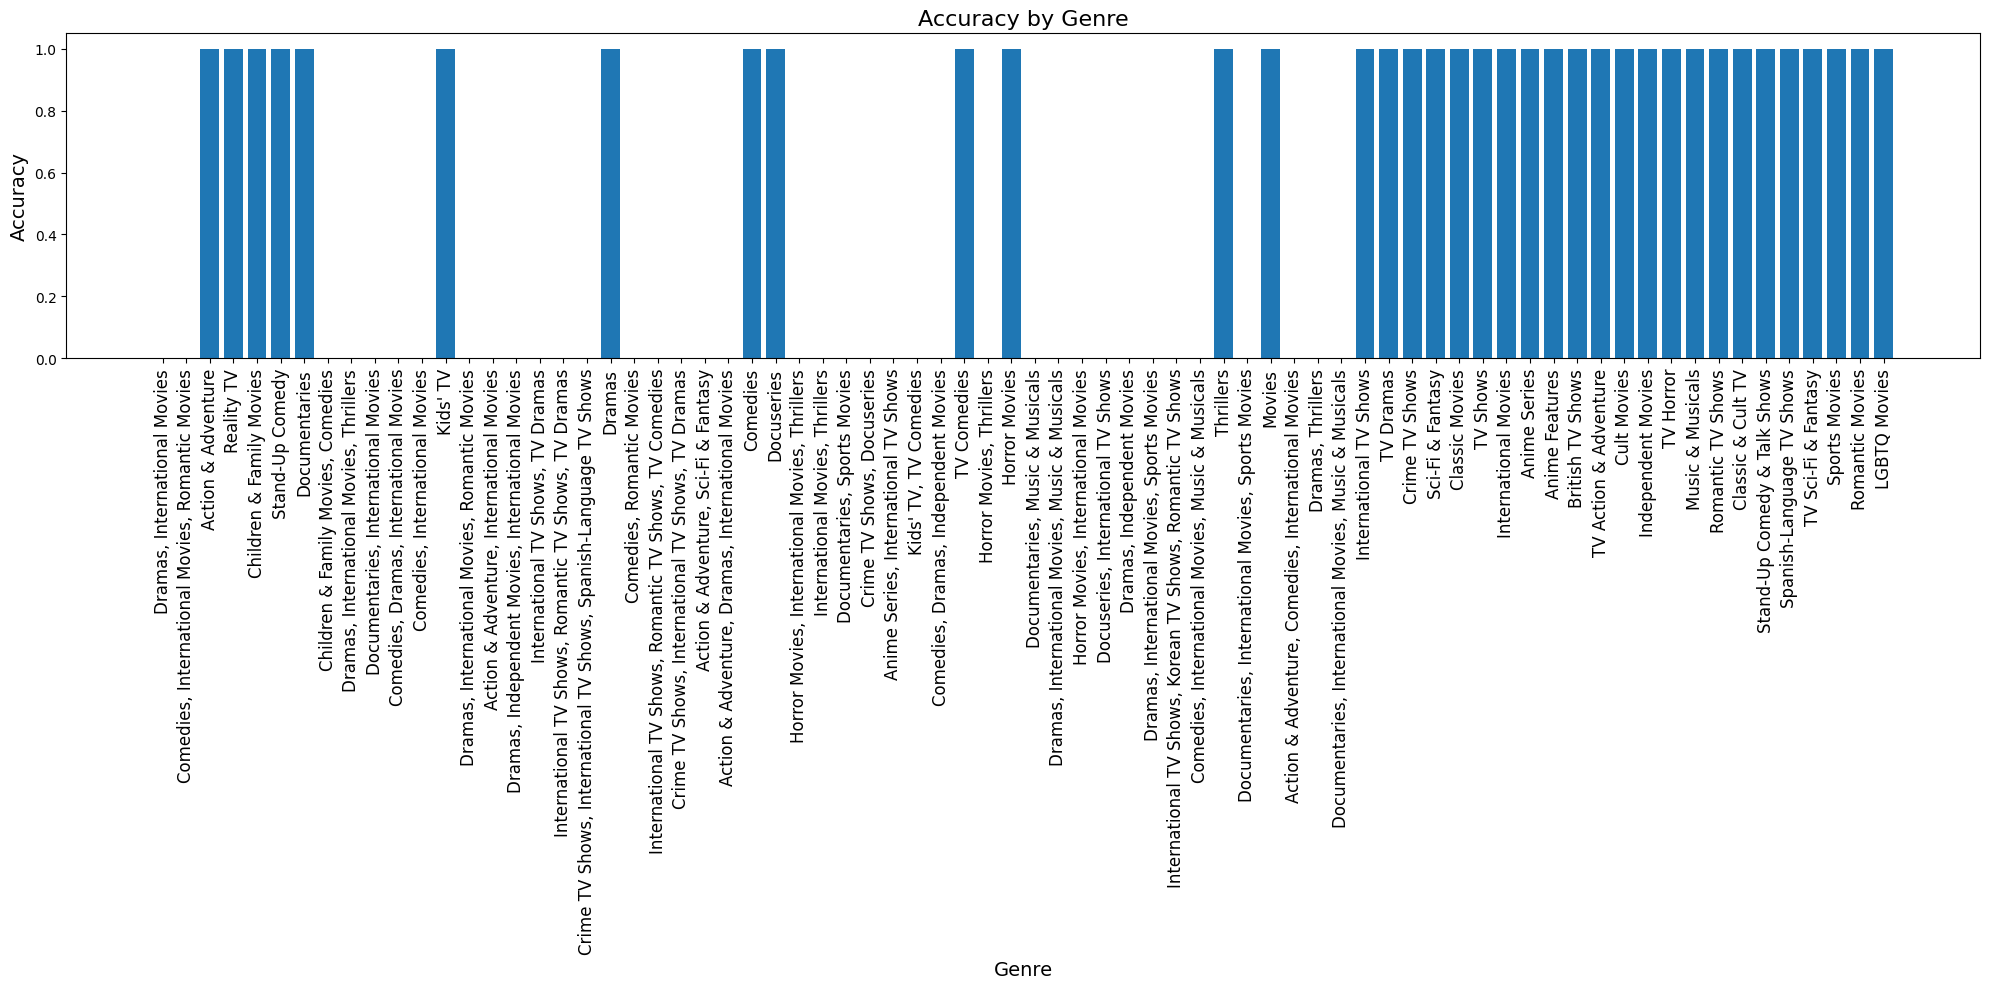

In [32]:
import matplotlib.pyplot as plt

#plot accuracies
plt.figure(figsize=(20, 10))  # Increase the figure size (width, height) as needed
plt.bar(accuracies.keys(), accuracies.values())
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy by Genre', fontsize=16)
plt.xticks(rotation=90, fontsize=12)  # Rotate the labels to vertical or to a suitable angle
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()